In [1]:
# todo: understand log_prob of evaluate

In [2]:
VERSION = 'sac,lr=1E-4'

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

import numpy as np
import math
import os

from collections import deque, defaultdict
import time
import random
from tqdm import tqdm

import minerl
import gym
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pickle
from typing import Deque, Dict, List, Tuple

import logging
import time

from IPython.display import clear_output
from IPython import display

logging.basicConfig(filename='logs/'+VERSION+'-'+time.strftime("%Y%m%d-%H%M%S")+'.log', 
                    filemode='w', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')

In [3]:
ACTIONS = ['attack', 'jump', 'forward', 'back', 'left', 'right', 'sprint', 'sneak', 'camera_hor', 'camera_ver']

SEED = 584
OBS_DIM = int(64*64*3+1) # pov + compassAngle
BUFFER_SIZE = int(1E5)

MAX_NUM_FRAMES = int(1E9)
BATCH_SIZE = 32

POV_SCALING = 255
COMPASS_SCALING = 180
TANH_FACTOR = 1
CAMERA_FACTOR = 1
NUM_FILTERS = 64

ACTOR_LR = 1E-4
CRITIC_LR = 1E-4
ALPHA_LR = 1E-4

GAMMA = 0.99
BUFFER_SIZE = int(1E5)

TAU = 0.001
USE_BN = True

INITIAL_ALPHA = 0.2

def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    env.seed(SEED)


### Buffer and random process

In [4]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(
        self, 
        obs_dim: int = OBS_DIM, 
        size: int = BUFFER_SIZE,
        act_dim: int = len(ACTIONS),
        batch_size: int = BATCH_SIZE,
#         n_step: int = 1, 
#         gamma: float = 0.99
    ):
        
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, act_dim], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0
        
#         # for N-step Learning
#         self.n_step_buffer = deque(maxlen=n_step)
#         self.n_step = n_step
#         self.gamma = gamma

    def store(
        self, 
        obs: np.ndarray, 
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ) -> None:
        
        transition = (obs, act, rew, next_obs, done)
#         self.n_step_buffer.append(transition)

#         # single step transition is not ready
#         if len(self.n_step_buffer) < self.n_step:
#             return ()
        
#         # make a n-step transition
#         rew, next_obs, done = self._get_n_step_info(
#             self.n_step_buffer, self.gamma
#         )
#         obs, act = self.n_step_buffer[0][:2]
        
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
#         return self.n_step_buffer[0]

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            dones=self.done_buf[idxs],
#             # for N-step Learning
#             indices=indices,
        )
    
    def __len__(self) -> int:
        return self.size

### SAC

In [5]:
class CriticNetwork(nn.Module):   
    def __init__(self, acts_dim=len(ACTIONS), num_filters=NUM_FILTERS):
        super(CriticNetwork, self).__init__()

        # Convolutional Block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=NUM_FILTERS, padding=0,
                               kernel_size=9, stride=1, bias=not USE_BN)   # output dim: 56
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)         # output dim: 28
        if USE_BN: self.bn1 = nn.BatchNorm2d(num_features=NUM_FILTERS)
        self.conv2 = nn.Conv2d(in_channels=NUM_FILTERS, out_channels=NUM_FILTERS, padding=1,stride=2,
                               kernel_size=4, bias=not USE_BN)    # output dim: 14
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output dim: 7
        if USE_BN: self.bn2 = nn.BatchNorm2d(num_features=NUM_FILTERS)

        # Fully connected layer
        self.linear1 = nn.Linear(NUM_FILTERS*7*7+acts_dim+1, 32) #todo: automatically calculate this
        self.linear2 = nn.Linear(32, 1)
        
        self.non_lin_1 = self.non_lin_2 = self.non_lin_3 = None

    def forward(self, obs_pov, obs_rest, acts):
        
        x = self.conv1(obs_pov.permute(0,3,1,2) / POV_SCALING)
        x = self.max_pool1(x)
        if USE_BN: x = self.bn1(x)
        self.non_lin_1 = F.elu(x)
        
        x = self.conv2(self.non_lin_1)
        x = self.max_pool2(x)
        if USE_BN: x = self.bn2(x)
        self.non_lin_2 = F.elu(x)
        
        x = x.view(self.non_lin_2.size(0), -1)
        x = self.linear1(torch.cat([x, obs_rest / COMPASS_SCALING, acts], dim=1))
        self.non_lin_3 = F.elu(x)
        out = self.linear2(self.non_lin_3)
        return out

In [6]:
class ActorNetwork(nn.Module):
    def __init__( self, acts_dim=len(ACTIONS), num_filters=NUM_FILTERS):
        super(ActorNetwork, self).__init__()

        # Convolutional Block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=num_filters, 
                               padding=0, kernel_size=9, stride=1, bias=not USE_BN)   # output dim: 56
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)         # output dim: 28
        if USE_BN: self.bn1 = nn.BatchNorm2d(num_features=num_filters)
        
        self.conv2 = nn.Conv2d(in_channels=num_filters, out_channels=num_filters, 
                               padding=1,stride=2, kernel_size=4, bias=not USE_BN)    # output dim: 14
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output dim: 7
        if USE_BN: self.bn2 = nn.BatchNorm2d(num_features=num_filters)

        # Fully connected layer
        self.linear1 = nn.Linear(num_filters*7*7+1, 32) #todo: automatically calculate this
        self.mean_linear= nn.Linear(32, acts_dim)
        self.log_std_linear= nn.Linear(32, acts_dim)
        
        self.non_lin_1 = self.non_lin_2 = self.non_lin_3 = None
        
        self.normal = Normal(0, 1)

    def forward(self, obs_pov, obs_rest):
        
        x = self.conv1(obs_pov.permute(0,3,1,2) / POV_SCALING)
        x = self.max_pool1(x)
        if USE_BN: x = self.bn1(x)
        self.non_lin_1 = F.elu(x)
        
        x = self.conv2(self.non_lin_1)
        x = self.max_pool2(x)
        if USE_BN: x = self.bn2(x)
        self.non_lin_2 = F.elu(x)
        
        x = x.view(self.non_lin_2.size(0), -1)
        x = self.linear1( torch.cat([x, obs_rest / COMPASS_SCALING], dim=1) )
        self.non_lin_3 = F.elu(x)
        mean = self.mean_linear(self.non_lin_3)
        log_std = self.log_std_linear(self.non_lin_3)
        #log_std = torch.clamp(log_std, -20, 2)
        return mean, log_std
    
    def get_log_probs(self, obs_pov, obs_rest, epsilon=1e-6):
        mean, log_std = self.forward(obs_pov, obs_rest)
        std = log_std.exp() # no clip in evaluation, clip affects gradients flow
        action_logit =   Normal(mean, std).sample()
        action = torch.tanh(action_logit)
        log_prob = Normal(mean, std).log_prob(action_logit) - torch.log(1. - action.pow(2) + epsilon) # -  np.log(self.action_range) # log(1)=0
        log_prob = log_prob.sum(dim=1, keepdim=True)
        return log_prob, action
    
    def get_action(self, obs_pov, obs_rest, deterministic=False):
        mean, log_std = self.forward(obs_pov, obs_rest)
        if deterministic:
            action = torch.tanh(mean)
        else:
            std = log_std.exp() # no clip in evaluation, clip affects gradients flow
            action_logit =  mean + std * self.normal.sample()
            action = torch.tanh(action_logit) # TanhNormal distribution as actions; reparameterization trick     
        return action
    
    

In [7]:
class Agent(object):

    def __init__(self, 
                 num_acts=len(ACTIONS),
                 batch_size=BATCH_SIZE, 
                 gamma=GAMMA,
                 actor_learning_rate=ACTOR_LR, 
                 critic_learning_rate=CRITIC_LR,
                 alpha_lr = ALPHA_LR,
                 tau=TAU,
                 buffer_capacity=BUFFER_SIZE,
                 initial_alpha=INITIAL_ALPHA
                 ):

        self.num_acts = num_acts
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        logging.info("Device is: "+str(self.device))
        print("Device is: ", self.device)
        
        self.gamma = gamma
        self.actor_lr = actor_learning_rate
        self.critic_lr = critic_learning_rate
        self.tau = tau
        self.buffer = ReplayBuffer()

        self.policy = ActorNetwork().to(self.device)
        
        self.q1 = CriticNetwork().to(self.device)
        self.q2 = CriticNetwork().to(self.device)
        self.target_q1 = CriticNetwork().to(self.device)
        self.target_q2 = CriticNetwork().to(self.device)
        self.log_alpha = torch.zeros(1, dtype=torch.float32, requires_grad=True, device=self.device)
        
        self.target_q1.load_state_dict(self.q1.state_dict())
        self.target_q2.load_state_dict(self.q2.state_dict())
        
        self.q1_optim = optim.Adam(self.q1.parameters(), lr=CRITIC_LR)
        self.q2_optim = optim.Adam(self.q2.parameters(), lr=CRITIC_LR)
        self.policy_optim = optim.Adam(self.policy.parameters(), lr=ACTOR_LR)
        self.alpha_optim = optim.Adam([self.log_alpha], lr=ALPHA_LR)
        
        self.target_entropy = -torch.prod(torch.Tensor(num_acts).to(self.device)).item()
        self.alpha = initial_alpha
        self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha_optim = optim.Adam([self.log_alpha], lr=alpha_lr)

    def get_act(self, obs_pov, obs_rest):
        
        self.policy.eval()
        with torch.no_grad():
            act = self.policy.get_action(obs_pov, obs_rest)
        self.policy.train()
        
        return act.cpu().numpy()
        
    def unflatten_obs(self, flat_obs):
        return (flat_obs[:,:-1].reshape(-1,64,64,3), flat_obs[:,-1].reshape(-1,1))
        
    def flatten_obs(self, obs):
        return np.append(obs['pov'].reshape(-1), obs['compassAngle'])

    # Store the transition into the replay buffer
    def store_transition(self, obs, next_obs, act, rew, done):
        obs = self.flatten_obs(obs)
        next_obs = self.flatten_obs(next_obs)
        self.buffer.store(obs=obs, act=act, rew=rew, 
                          next_obs=next_obs, done=done)

    def float_tensor(self, numpy_array):
        return torch.FloatTensor(numpy_array).to(self.device)
        
    def fit_batch(self):
        # Sample frorm buffer
        transitions = self.buffer.sample_batch()
        
        obss_pov, obss_rest = self.unflatten_obs(self.float_tensor(transitions['obs']))
        next_obss_pov, next_obss_rest = self.unflatten_obs(self.float_tensor(transitions['next_obs']))
        acts = self.float_tensor(transitions['acts'])
        rews = self.float_tensor(transitions['rews'])
        dones = self.float_tensor(transitions['dones'])
        
        # Q function loss
        with torch.no_grad():
            next_log_prob, next_action = self.policy.get_log_probs(next_obss_pov, next_obss_rest)
            target_q1_next = self.target_q1(next_obss_pov, next_obss_rest, next_action)
            target_q2_next = self.target_q2(next_obss_pov, next_obss_rest, next_action)
            min_q_target_hat = torch.min(target_q1_next, target_q2_next) - self.alpha * next_log_prob # UNDERSTAND
            y = rews + (1 - dones) * self.gamma * min_q_target_hat.view(-1)
        
        q1_hat = self.q1( obss_pov, obss_rest , acts ).view(-1)  
        q2_hat = self.q2( obss_pov, obss_rest , acts ).view(-1)  
        q1_loss = F.mse_loss(q1_hat, y) 
        q2_loss = F.mse_loss(q2_hat, y)
        
        # Policy loss
        #import pdb; pdb.set_trace()
        log_pi, pi = self.policy.get_log_probs(obss_pov, obss_rest)
        
        q1_hat_policy = self.q1(obss_pov, obss_rest, pi)
        q2_hat_policy = self.q2(obss_pov, obss_rest, pi)
        min_q_pi = torch.min(q1_hat_policy, q2_hat_policy)

        policy_loss = ((self.alpha * log_pi) - min_q_pi).mean() # Jπ = 𝔼st∼D,εt∼N[α * logπ(f(εt;st)|st) − Q(st,f(εt;st))]
        
        # Gradient descent
        self.q1_optim.zero_grad()
        q1_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q1.parameters(), 1.0, norm_type=1)
        self.q1_optim.step()
        
        self.q2_optim.zero_grad()
        q2_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q2.parameters(), 1.0, norm_type=1)
        self.q2_optim.step()
        
        self.policy_optim.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0, norm_type=1)
        self.policy_optim.step()
        
        # Alpha parameter tuning      
        alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()

        self.alpha_optim.zero_grad()
        alpha_loss.backward()
        #torch.nn.utils.clip_grad_norm_(self.log_alpha.parameters(), 1.0, norm_type=1)
        self.alpha_optim.step()

        self.alpha = self.log_alpha.exp()

        return q1_loss, q2_loss, policy_loss, q1_hat, q2_hat
    
    def update_target_networks(self):
        self.polyak_averaging(self.target_q1, self.q1)
        self.polyak_averaging(self.target_q2, self.q2)
        
    def polyak_averaging(self, target, original):
        for target_param, param in zip(target.parameters(), original.parameters()):
            target_param.data.copy_(self.tau * param.data + target_param.data * (1.0 - self.tau))

### Instantiate

In [8]:
if 'environment_name' not in locals():
    environment_name = 'MineRLNavigateDense-v0'
    %time env = gym.make(environment_name)

seed_everything()

CPU times: user 215 ms, sys: 295 ms, total: 510 ms
Wall time: 1min 2s


In [9]:
agent = Agent()

# number of trainable parameters of model
message_1 = 'Number of trainable parameters actor:' + str(sum(p.numel() for p in agent.policy.parameters()  if p.requires_grad))
message_2 = 'Number of trainable parameters critic:'+str(sum(p.numel() for p in agent.q1.parameters()  if p.requires_grad)*2)
message_3 = 'Number of trainable parameters alpha:'+' Unknown'
print(message_1)
print(message_2)
print(message_3)

logging.info(message_1)
logging.info(message_2)

Device is:  cuda
Number of trainable parameters actor:182420
Number of trainable parameters critic:364226
Number of trainable parameters alpha: Unknown


In [10]:
# Load agent
# agent.actor.load_state_dict(torch.load('trained_models/ddpg_actor_'+VERSION+'.pkl'))
# agent.critic.load_state_dict(torch.load('trained_models/ddpg_critic_'+VERSION+'.pkl'))

### Training loop

In [11]:
def get_env_act(model_act):
    '''
    Gets environment act from model act
    '''
    env_act = {act: int(value>0) for act, value in zip(ACTIONS[0:8], model_act[0:8])}
    env_act['camera'] = [model_act[8]*180, model_act[9]*180]
    return env_act

def plot_stats(
        frame_idx: int, 
        scores: List[float],
        current_score: List[float],
        losses: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('q_values')
        plt.plot(scores[-10000:])
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('current_score')
        plt.plot(current_score)
        plt.show()

In [12]:
%time obs = env.reset()
assert (agent.unflatten_obs( np.array([agent.flatten_obs(obs)]) )[0][0].astype(int) == obs['pov']).sum() == 3*64*64
update_cnt = 0
losses_agent = []
losses_critic = []
scores = []
current_score = []
current_scores = []
max_parameters = []
plotting_interval = 100
score = 0
logging.info('Environment reset')

q1_values_mean=[]
q2_values_mean=[]
losses_agent=[]
losses_q1=[]
losses_q2=[]


CPU times: user 2.13 ms, sys: 10.7 ms, total: 12.9 ms
Wall time: 27.1 s


In [13]:
def check_relus_are_alive():
    for network in [agent.q1, agent.q2, agent.policy]:
        if float(network.non_lin_1.sum()) == 0:
            text = str(network) + ' has non_lin_1 died'
            logging.info(text)
            print(text)
        if float(network.non_lin_2.sum()) == 0:
            text = str(network) + ' has non_lin_2 died'
            logging.info(text)
            print(text)
        if float(network.non_lin_3.sum()) == 0:
            text = str(network) + ' has non_lin_3 died'
            logging.info(text)
            print(text)
            
# test
# agent.actor.x_relu_1[agent.actor.x_relu_1!=0] = 0

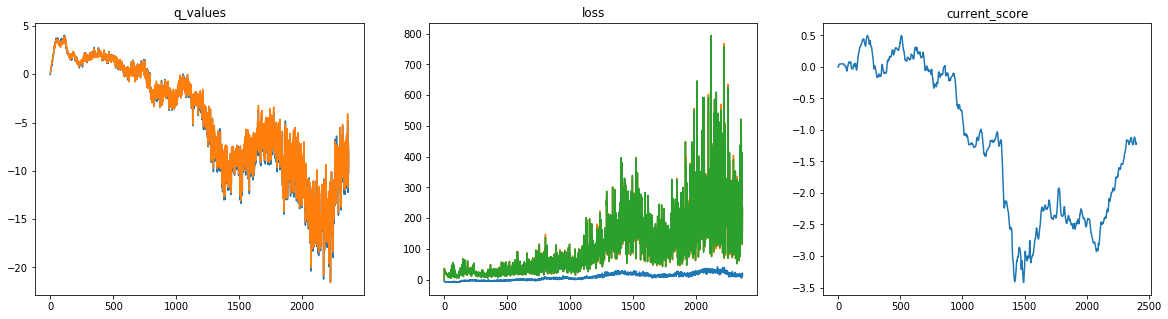

frame:   0%|          | 2460/1000000000 [08:11<47176:18:06,  5.89it/s] 

In [ ]:
for frame_idx in tqdm(range(MAX_NUM_FRAMES), desc='frame'):
    obs_pov = agent.float_tensor([obs['pov'].astype(float)])
    obs_rest = agent.float_tensor([[obs['compassAngle']]])
    model_act = agent.get_act(obs_pov, obs_rest)
    env_act = get_env_act(model_act[0])
    next_obs, rew, done, info = env.step(env_act)

    # Store the transition in the replay buffer of the agent
    agent.store_transition(obs=obs, next_obs=next_obs,
                               act=model_act, done=done, rew=rew)
    
    # Prepare for next step and store scores
    obs = next_obs
    score += rew
    current_score.append(score)

    # if episode ends
    if done:
        obs = env.reset()
        current_scores.append(current_score)
        scores.append(score)
        pickle.dump(current_scores, open('scores/current_score_'+VERSION+'.pkl', 'wb'))
        pickle.dump(scores, open('scores/scores_'+VERSION+'.pkl', 'wb'))
        current_score = []
        score = 0
        torch.save(agent.policy.state_dict(), 'trained_models/sac_policy'+VERSION+'.pkl')
        torch.save(agent.q1.state_dict(), 'trained_models/sac_q1'+VERSION+'.pkl')
        torch.save(agent.q2.state_dict(), 'trained_models/sac_q2'+VERSION+'.pkl')
        logging.info(f'Trajectory {len(current_scores)} done, with final score {current_scores[-1][-1]}')

    # TRAIN
    if len(agent.buffer) >= agent.batch_size:
        q1_loss, q2_loss, policy_loss, q1_hat, q2_hat = agent.fit_batch()
        agent.update_target_networks()
        q1_hat_mean = float(q1_hat.mean())
        q2_hat_mean = float(q2_hat.mean())
        
        assert (q1_hat_mean==q1_hat_mean) or (q2_hat_mean==q2_hat_mean), "At least one q function returns NaN!"
        
        q1_values_mean.append(q1_hat_mean)
        q2_values_mean.append(q2_hat_mean)
        
        losses_agent.append(float(policy_loss))
        losses_q1.append(float(q1_loss))
        losses_q2.append(float(q2_loss))

    if (frame_idx+1) % plotting_interval == 0:
        
        pickle.dump([q1_values_mean, q2_values_mean], open('logs/q_values_'+VERSION+'.pkl','wb'))
        check_relus_are_alive()
        
        plot_stats(frame_idx, 
                   np.array([q1_values_mean, q2_values_mean]).T, 
                   current_score,
                   np.array([losses_agent, losses_q1, losses_q2]).T)
        
        

In [ ]:
%debug

In [ ]:
{'q1_loss': float(q1_loss), 
                'q2_loss': float(q2_loss), 
                'policy_loss': float(policy_loss), 
                'q1_hat': float(q1_hat),
                'q2_hat': float(q2_hat), 
                'y': float(y)}

In [ ]:
obs = env.reset()
net_reward = 0
actions = []

In [ ]:
for i in range(200):
    import pdb; pdb.set_trace()
    obs_pov = agent.float_tensor([obs['pov'].astype(float)])
    obs_rest = agent.float_tensor([[obs['compassAngle']]])
    model_act = agent.get_act(obs_pov,obs_rest)
    env_act = get_env_act(model_act[0])
    next_obs, rew, done, info = env.step(env_act)

    # Prepare for next step and store scores
    obs = next_obs
    score += rew
    current_score.append(score)
    
#     if i%10==0:
    plt.imshow(env.render(mode='rgb_array')) 
    display.display(plt.gcf())
    clear_output(wait=True)
    net_reward += rew
    actions.append((env_act, net_reward))

In [ ]:
list(agent.actor.conv2.parameters())

In [ ]:
"""
Class for a generic trainer used for training all the different reinforcement learning models
"""
class Trainer(object):

    def __init__(self, agent, num_epochs,
                 num_rollouts, num_eval_rollouts, env, eval_env, nb_train_steps,
                 max_episodes_per_epoch, 
                 output_folder=None, her_training=False,
                 save_model=False, future=None):

        """

        :param ddpg: The ddpg network
        :param num_rollouts: number of experience gathering rollouts per episode
        :param num_eval_rollouts: number of evaluation rollouts
        :param num_episodes: number of episodes per epoch
        :param env: Gym environment to train on
        :param eval_env: Gym environment to evaluate on
        :param nb_train_steps: training steps to take
        :param max_episodes_per_epoch: maximum number of episodes per epoch
        :param her_training: use hindsight experience replay
        :param multi_gpu_training: train on multiple gpus
        """

        self.ddpg = agent
        self.num_epochs = num_epochs
        self.num_rollouts = num_rollouts
        self.num_eval_rollouts = num_eval_rollouts
        self.env = env
        self.eval_env = eval_env
        self.nb_train_steps = nb_train_steps
        self.max_episodes = max_episodes_per_epoch
        self.her = her_training
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Device is: ", self.device)
        self.output_folder = output_folder
        self.future = future

        self.all_rews = []
        self.successes = []

        # Get the target  and standard networks
        self.target_actor = self.ddpg.get_actors()['target']
        self.actor = self.ddpg.get_actors()['actor']
        self.target_critic  = self.ddpg.get_critics()['target']
        self.critic = self.ddpg.get_critics()['critic']
        self.statistics = defaultdict(float)
        self.combined_statistics = defaultdict(list)


    def train(self):

        # Starting time
        start_time = time.time()

        # Initialize the statistics dictionary
        statistics = self.statistics

        episode_rews_history = deque(maxlen=100)
        eval_episode_rews_history = deque(maxlen=100)
        episode_success_history = deque(maxlen=100)
        eval_episode_success_history = deque(maxlen=100)

        epoch_episode_rews = []
        epoch_episode_success = []
        epoch_episode_steps = []

        # Epoch rews and success
        epoch_rews = []
        epoch_success = []

        # Initialize the training with an initial obs
        obs = self.env.reset()
        # If eval, initialize the evaluation with an initial obs
        if self.eval_env is not None:
            eval_obs = self.eval_env.reset()
            eval_obs = to_tensor(eval_obs, use_cuda=self.cuda)
            eval_obs = torch.unsqueeze(eval_obs, dim=0)

        # Initialize the losses
        loss = 0
        episode_rew =  0
        episode_success = 0
        episode_step = 0
        epoch_acts = []
        t = 0

        # Check whether to use cuda or not
        obs = to_tensor(obs, use_cuda=self.cuda)
        obs = torch.unsqueeze(obs, dim=0)

        # Main training loop
        for epoch in range(self.num_epochs):
            epoch_actor_losses = []
            epoch_critic_losses = []
            for episode in range(self.max_episodes):

                # Rollout of trajectory to fill the replay buffer before training
                for rollout in range(self.num_rollouts):
                    # Sample an act from behavioural policy pi
                    act = self.ddpg.get_act(obs=obs, noise=True)
                    assert act.shape == self.env.get_act_shape

                    # Execute next act
                    new_obs, rew, done, success = self.env.step(act)
                    success = success['is_success']
                    done_bool = done * 1

                    t+=1
                    episode_rew += rew
                    episode_step += 1
                    episode_success += success

                    # Book keeping
                    epoch_acts.append(act)
                    # Store the transition in the replay buffer of the agent
                    self.ddpg.store_transition(obs=obs, new_obs=new_obs,
                                               act=act, done=done_bool, rew=rew,
                                               success=success)
                    # Set the current obs as the next obs
                    obs = to_tensor(new_obs, use_cuda=self.cuda)
                    obs = torch.unsqueeze(obs, dim=0)

                    # End of the episode
                    if done:
                        epoch_episode_rews.append(episode_rew)
                        episode_rews_history.append(episode_rew)
                        episode_success_history.append(episode_success)
                        epoch_episode_success.append(episode_success)
                        epoch_episode_steps.append(episode_step)
                        episode_rew = 0
                        episode_step = 0
                        episode_success = 0

                        # Reset the agent
                        self.ddpg.reset()
                        # Get a new initial obs to start from
                        obs = self.env.reset()
                        obs = to_tensor(obs, use_cuda=self.cuda)

                # Train
                for train_steps in range(self.nb_train_steps):
                    critic_loss, actor_loss = self.ddpg.fit_batch()
                    if critic_loss is not None and actor_loss is not None:
                        epoch_critic_losses.append(critic_loss)
                        epoch_actor_losses.append(actor_loss)

                    # Update the target networks using polyak averaging
                    self.ddpg.update_target_networks()

                eval_episode_rews = []
                eval_episode_successes = []
                if self.eval_env is not None:
                    eval_episode_rew = 0
                    eval_episode_success = 0
                    for t_rollout in range(self.num_eval_rollouts):
                        if eval_obs is not None:
                            eval_act = self.ddpg.get_act(obs=eval_obs, noise=False)
                        eval_new_obs, eval_rew, eval_done, eval_success = self.eval_env.step(eval_act)
                        eval_episode_rew += eval_rew
                        eval_episode_success += eval_success

                        if eval_done:
                            eval_obs = self.eval_env.reset()
                            eval_obs = to_tensor(eval_obs, use_cuda=self.cuda)
                            eval_obs = torch.unsqueeze(eval_obs, dim=0)
                            eval_episode_rews.append(eval_episode_rew)
                            eval_episode_rews_history.append(eval_episode_rew)
                            eval_episode_successes.append(eval_episode_success)
                            eval_episode_success_history.append(eval_episode_success)
                            eval_episode_rew = 0
                            eval_episode_success = 0

            # Log stats
            duration = time.time() - start_time
            statistics['rollout/rews'] = np.mean(epoch_episode_rews)
            statistics['rollout/rews_history'] = np.mean(episode_rews_history)
            statistics['rollout/successes'] = np.mean(epoch_episode_success)
            statistics['rollout/successes_history'] = np.mean(episode_success_history)
            statistics['rollout/acts_mean'] = np.mean(epoch_acts)
            statistics['train/loss_actor'] = np.mean(epoch_actor_losses)
            statistics['train/loss_critic'] = np.mean(epoch_critic_losses)
            statistics['total/duration'] = duration

            # Evaluation statistics
            if self.eval_env is not None:
                statistics['eval/rews'] = np.mean(eval_episode_rews)
                statistics['eval/rews_history'] = np.mean(eval_episode_rews_history)
                statistics['eval/successes'] = np.mean(eval_episode_successes)
                statistics['eval/success_history'] = np.mean(eval_episode_success_history)

            # Print the statistics
            if self.verbose:
                if epoch % 5 == 0:
                    print("Actor Loss: ", statistics['train/loss_actor'])
                    print("Critic Loss: ", statistics['train/loss_critic'])
                    print("rew ", statistics['rollout/rews'])
                    print("Successes ", statistics['rollout/successes'])

                    if self.eval_env is not None:
                        print("Evaluation rew ", statistics['eval/rews'])
                        print("Evaluation Successes ", statistics['eval/successes'])

            # Log the combined statistics for all epochs
            for key in sorted(statistics.keys()):
                self.combined_statistics[key].append(statistics[key])

            # Log the epoch rews and successes
            epoch_rews.append(np.mean(epoch_episode_rews))
            epoch_success.append(np.mean(epoch_episode_success))

        # Plot the statistics calculated
        if self.plot_stats:
            # Plot the rews and successes
            rews_fname = self.output_folder + '/rews.jpg'
            success_fname = self.output_folder + '/success.jpg'
            plot(epoch_rews, f_name=rews_fname, save_fig=True, show_fig=False)
            plot(epoch_success, f_name=success_fname, save_fig=True, show_fig=False)

        # Save the models on the disk
        if self.save_model:
            self.ddpg.save_model(self.output_folder)

        return self.combined_statistics

    def get_frames(self, transition, sample_experience, k):
        """

        :param transition: Current transition -> Goal substitution
        :param sample_experience: The Future episode experiences
        :param k: The number of transitions to consider
        :return:
        """
        # Get the frames predicted by our self attention network
        seq_length = len(sample_experience)
        obss = []
        new_obss= []
        rews = []
        successes = []
        acts = []
        dones = []
        for t in sample_experience:
            obs, new_obs, rew, success, act, done_bool = t
            obs = np.concatenate(obs[:self.ddpg.obs_dim], obs['achieved_goal'])
            new_obs = np.concatenate(new_obs[:self.ddpg.obs_dim], new_obs['achieved_goal'])
            obss.append(obs)
            new_obss.append(new_obs[:self.ddpg.obs_dim])
            rews.append(rew)
            successes.append(success)
            acts.append(act)
            dones.append(done_bool)

        # Input Sequence consists of n embeddings of obss||achieved_goals
        input_sequence = Variable(torch.cat(obss))
        # The Query vector is the current obs || desired goal
        obs, new_obs, rew, success, act, done_bool = transition
        query = Variable(obs)

        # The Goal Network
        gn = GoalNetwork(input_dim=seq_length, embedding_dim=self.ddpg.input_dim,
                         query_dim=self.ddpg.input_dim, num_hidden=self.ddpg.num_hidden_units,
                         output_features=1, use_additive=True, use_self_attn=True, use_token2token=True,
                         activation=nn.ReLU)

        if self.cuda:
            input_sequence = input_sequence.cuda()
            query = query.cuda()
            gn = gn.cuda()

        scores = gn(input_sequence, query)
        optimizer_gn = optim.Adam(gn.parameters(), lr=self.ddpg.actor_lr)
        optimizer_gn.zero_grad()
        # Dimension of the scores vector is 1 x n
        # Find the top 5 maximum values from the scores vector and their indexes
        values, indices = torch.topk(scores, k, largest=True)
        # Now we have the indices -> Get the corresponding experiences
        top_experiences = []
        for m in indices:
            top_experiences.append(sample_experience[m])

        # Training Step
        TD_error = 0
        for t in top_experiences:
            TD_error += self.ddpg.calc_td_error(t)
        loss = -1 * (TD_error.mean())
        loss.backward()
        # Clamp the gradients to avoid the vanishing gradient problem
        for param in gn.parameters():
            param.grad.data.clamp_(-1, 1)
        optimizer_gn.step()

        return top_experiences



#### Code for the "her" part

In [ ]:
#     def sample_goals(self,sampling_strategy, experience, future=None, transition=None):
#         g = []
#         if sampling_strategy == 'final':
#             n_s = experience[len(experience)-1]
#             g.append(n_s['achieved_goal'])

#         elif sampling_strategy == 'self_attention':
#             if transition is not None:
#                 index_of_t = experience.index(transition)
#                 sample_experience = experience[index_of_t:]
#                 if future is None:
#                     future = 5
#                 frames = self.get_frames(transition, sample_experience, k=future)
#                 for f in frames:
#                     g.append(f['achieved_goal'])

#         elif sampling_strategy == 'future':
#             if transition is not None and future is not None:
#                 index_of_t = transition
#                 if index_of_t < len(experience)-2:
#                     sample_experience = experience[index_of_t+1:]
#                     random_transitions = random.sample(population=sample_experience,
#                                               k=future)
#                     for f in random_transitions:
#                         observation, new_observation, obs, new_obs, rew, success, act, done_bool, achieved_goal, desired_goal = f
#                         g.append(achieved_goal)

#         elif sampling_strategy == 'prioritized':
#             pass

#         return g

#     def her_training(self):

#         # Starting Time
#         start_time = time.time()

#         # Initialize the statistics dictionary
#         statistics = self.statistics

#         episode_rews_history = deque(maxlen=100)
#         episode_revised_rews_history  =  deque(maxlen=100)
#         eval_episode_rews_history = deque(maxlen=100)
#         episode_success_history = deque(maxlen=100)
#         eval_episode_success_history = deque(maxlen=100)
#         episode_goals_history = deque(maxlen=100)
#         eval_episode_goals_history = deque(maxlen=100)
#         all_goals_history = deque(maxlen=100)

#         epoch_episode_rews = []
#         epoch_episode_success = []
#         epoch_episode_steps = []


#         episode_obss_history = deque(maxlen=100)
#         episode_new_obss_history = deque(maxlen=100)

#         # rews and success for each epoch
#         epoch_rews = []
#         epoch_success = []

#         # Sample a goal g and an initial obs s0
#         obs = self.env.reset() # The obs space includes the observation, achieved_goal and the desired_goal
#         observation = obs['observation']
#         achieved_goal = obs['achieved_goal']
#         desired_goal = obs['desired_goal']
#         obs = np.concatenate((observation, desired_goal))

#         # If eval, initialize the evaluation with an initial obs
#         if self.eval_env is not None:
#             eval_obs = self.eval_env.reset()
#             eval_observation = eval_obs['observation']
#             eval_achieved_goal = eval_obs['achieved_goal']
#             eval_desired_goal = eval_obs['desired_goal']
#             eval_obs = np.concatenate((eval_observation, eval_desired_goal))
#             eval_obs = to_tensor(eval_obs, use_cuda=self.cuda)
#             eval_obs = torch.unsqueeze(eval_obs, dim=0)

#         # Initialize the losses
#         loss = 0
#         episode_rew = 0
#         episode_success = 0
#         episode_step = 0
#         epoch_acts = []
#         t = 0

#         # Check whether to use cuda or not
#         obs = to_tensor(obs, use_cuda=self.cuda)
#         obs = torch.unsqueeze(obs, dim=0)

#         for epoch in range(self.num_epochs):
#             epoch_actor_losses = []
#             epoch_critic_losses = []

#             for cycle in range(self.max_episodes):

#                 # States and new obss for the hindsight experience replay
#                 episode_obss = []
#                 episode_achieved_goals = []
#                 episode_desired_goals = []
#                 episode_new_obss = []
#                 episode_rews = []
#                 episode_successes = []
#                 episode_acts = []
#                 episode_dones = []
#                 episode_experience = []
#                 episode_observations = []
#                 episode_new_observations = []

#                 # Rollout of trajectory to fill the replay buffer before the training
#                 for rollout in range(self.num_rollouts):
#                     # Sample an act from behavioural policy pi
#                     act = self.ddpg.get_act(obs=obs, noise=True)
#                     #assert act.shape == self.env.get_act_shape

#                     # Execute the act and observe the new obs
#                     new_obs, rew, done, success = self.env.step(act)

#                     # The following has to hold
#                     assert rew == self.env.compute_rew(
#                         new_obs['achieved_goal'], new_obs['desired_goal'],
#                         info=success
#                     )

#                     new_observation = new_obs['observation']
#                     new_achieved_goal = new_obs['achieved_goal']
#                     new_desired_goal = new_obs['desired_goal']
#                     new_obs = np.concatenate((new_observation, new_desired_goal))
#                     new_obs = to_tensor(new_obs, self.cuda)
#                     #new_obs = torch.unsqueeze(new_obs, dim=0)
#                     success = success['is_success']
#                     done_bool = done * 1

#                     episode_obss.append(obs)
#                     episode_new_obss.append(new_obs)
#                     episode_rews.append(rew)
#                     episode_successes.append(success)
#                     episode_acts.append(act)
#                     episode_dones.append(done_bool)
#                     episode_achieved_goals.append(new_achieved_goal)
#                     episode_desired_goals.append(new_desired_goal)
#                     episode_observations.append(observation)
#                     episode_new_observations.append(new_observation)
#                     episode_experience.append(
#                         (observation, new_observation, obs, new_obs, rew, success, act, done_bool, new_achieved_goal, desired_goal)
#                     )

#                     t += 1
#                     episode_rew += rew
#                     episode_step += 1
#                     episode_success += success

#                     # Set the current obs as the next obs
#                     obs = to_tensor(new_obs, use_cuda=self.cuda)
#                     obs = torch.unsqueeze(obs, dim=0)
#                     observation = new_observation

#                     # End of the episode
#                     if done:
#                         # Get the episode goal
#                         #episode_goal = new_obs[:self.ddpg.obs_dim]
#                         #episode_goals_history.append(episode_goal)
#                         epoch_episode_rews.append(episode_rew)
#                         episode_goals_history.append(achieved_goal)
#                         episode_rews_history.append(episode_rew)
#                         episode_success_history.append(episode_success)
#                         epoch_episode_success.append(episode_success)
#                         epoch_episode_steps.append(episode_step)
#                         episode_rew = 0
#                         episode_step = 0
#                         episode_success = 0

#                         # Reset the agent
#                         self.ddpg.reset()
#                         # Get a new initial obs to start from
#                         obs = self.env.reset()
#                         observation = obs['observation']
#                         achieved_goal = obs['achieved_goal']
#                         desired_goal = obs['desired_goal']
#                         obs = np.concatenate((observation, desired_goal))
#                         obs = to_tensor(obs, use_cuda=self.cuda)
#                         obs = torch.unsqueeze(obs, dim=0)

#                 # Standard Experience Replay
#                 i = 0
#                 for tr in episode_experience:
#                     observation, new_observation, obs, new_obs, rew, success, act, done_bool, achieved_goal, desired_goal = tr
#                     new_obs = torch.unsqueeze(new_obs, dim=0)
#                     act = to_tensor(act, use_cuda=self.cuda)
#                     act = torch.unsqueeze(act, dim=0)
#                     rew = to_tensor([np.asscalar(rew)], use_cuda=self.cuda)
#                     done_bool = to_tensor([done_bool], use_cuda=self.cuda)
#                     #success = to_tensor([np.asscalar(success)], use_cuda=self.cuda)

#                     # Store the transition in the experience replay
#                     self.ddpg.store_transition(
#                         obs=obs, new_obs=new_obs, rew=rew,
#                         success=success, act=act, done=done_bool
#                     )

#                     # Hindsight Experience Replay
#                     # Sample a set of additional goals for replay G: S
#                     additional_goals = self.sample_goals(sampling_strategy='future',
#                                                          experience=episode_experience,
#                                                          future=self.future, transition=i)

#                     for g in additional_goals:
#                         # Recalculate the rew
#                         substitute_goal = g

#                         # Recalculate the rew now when the desired goal is the substituted goal
#                         # which is the achieved goal sampled using the sampling strategy
#                         rew_revised = self.env.compute_rew(
#                             achieved_goal, substitute_goal, info=success
#                         )
#                         # Book Keeping
#                         #episode_revised_rews_history.append(rew_revised)
#                         # Store the transition with the new goal and rew in the replay buffer
#                         # Get the observation and new observation from the concatenated value

#                         # Currently, the env on resetting returns a concatenated vector of
#                         # Observation and the desired goal. Therefore, we need to extract the
#                         # Observation for this step.
#                         observation = to_tensor(observation, use_cuda=self.cuda)
#                         new_observation = to_tensor(new_observation, use_cuda=self.cuda)

#                         g = to_tensor(g, use_cuda=self.cuda)
#                         #rew_revised = to_tensor(rew_revised, use_cuda=self.cuda)
#                         #print(observation)
#                         augmented_obs = torch.cat([observation, g])
#                         augmented_new_obs = torch.cat([new_observation, g])
#                         augmented_obs = torch.unsqueeze(augmented_obs, dim=0)
#                         augmented_new_obs = torch.unsqueeze(augmented_new_obs, dim=0)
#                         rew_revised = to_tensor([np.asscalar(rew_revised)], use_cuda=self.cuda)

#                         # Store the transition in the buffer
#                         self.ddpg.store_transition(obs=augmented_obs, new_obs=augmented_new_obs,
#                                                    act=act, done=done_bool, rew=rew_revised,
#                                                    success=success)

#                 # Train the network
#                 for train_steps in range(self.nb_train_steps):
#                     critic_loss, actor_loss = self.ddpg.fit_batch()
#                     if critic_loss is not None and actor_loss is not None:
#                         epoch_critic_losses.append(critic_loss)
#                         epoch_actor_losses.append(actor_loss)

#                     # Update the target networks using polyak averaging
#                     self.ddpg.update_target_networks()

#                 eval_episode_rews = []
#                 eval_episode_successes = []
#                 if self.eval_env is not None:
#                     eval_episode_rew = 0
#                     eval_episode_success = 0
#                     for t_rollout in range(self.num_eval_rollouts):
#                         if eval_obs is not None:
#                             eval_act = self.ddpg.get_act(obs=eval_obs, noise=False)
#                         eval_new_obs, eval_rew, eval_done, eval_success = self.eval_env.step(eval_act)
#                         eval_episode_rew += eval_rew
#                         eval_episode_success += eval_success['is_success']

#                         if eval_done:
#                             # Get the episode goal
#                             #eval_episode_goal = eval_new_obs[:self.ddpg.obs_dim]
#                             #eval_episode_goals_history.append(eval_episode_goal)
#                             eval_obs = self.eval_env.reset()
#                             eval_obs = to_tensor(eval_obs, use_cuda=self.cuda)
#                             eval_obs = torch.unsqueeze(eval_obs, dim=0)
#                             eval_episode_rews.append(eval_episode_rew)
#                             eval_episode_rews_history.append(eval_episode_rew)
#                             eval_episode_successes.append(eval_episode_success)
#                             eval_episode_success_history.append(eval_episode_success)
#                             eval_episode_rew = 0
#                             eval_episode_success = 0

#                 # Log stats
#                 duration = time.time() - start_time
#                 statistics['rollout/rews'] = np.mean(epoch_episode_rews)
#                 statistics['rollout/rews_history'] = np.mean(episode_rews_history)
#                 statistics['rollout/successes'] = np.mean(epoch_episode_success)
#                 statistics['rollout/successes_history'] = np.mean(episode_success_history)
#                 statistics['rollout/acts_mean'] = np.mean(epoch_acts)
#                 statistics['rollout/goals_mean'] = np.mean(episode_goals_history)
#                 statistics['train/loss_actor'] = np.mean(epoch_actor_losses)
#                 statistics['train/loss_critic'] = np.mean(epoch_critic_losses)
#                 statistics['total/duration'] = duration

#                 # Evaluation statistics
#                 if self.eval_env is not None:
#                     statistics['eval/rews'] = np.mean(eval_episode_rews)
#                     statistics['eval/rews_history'] = np.mean(eval_episode_rews_history)
#                     statistics['eval/successes'] = np.mean(eval_episode_successes)
#                     statistics['eval/success_history'] = np.mean(eval_episode_success_history)
#                     statistics['eval/goals_history'] = np.mean(eval_episode_goals_history)

#             # Print the statistics
#             if self.verbose:
#                 if epoch % 5 == 0:
#                     print(epoch)
#                     print("rew ", statistics['rollout/rews'])
#                     print("Successes ", statistics['rollout/successes'])

#                     if self.eval_env is not None:
#                         print("Evaluation rew ", statistics['eval/rews'])
#                         print("Evaluation Successes ", statistics['eval/successes'])

#             # Log the combined statistics for all epochs
#             for key in sorted(statistics.keys()):
#                 self.combined_statistics[key].append(statistics[key])

#             # Log the epoch rews and successes
#             epoch_rews.append(np.mean(epoch_episode_rews))
#             epoch_success.append(np.mean(epoch_episode_success))

#         # Plot the statistics calculated
#         if self.plot_stats:
#             # Plot the rews and successes
#             rews_fname = self.output_folder + '/rews.jpg'
#             success_fname = self.output_folder + '/success.jpg'
#             plot(epoch_rews, f_name=rews_fname, save_fig=True, show_fig=False)
#             plot(epoch_success, f_name=success_fname, save_fig=True, show_fig=False)

#         # Save the models on the disk
#         if self.save_model:
#             self.ddpg.save_model(self.output_folder)

#         return self.combined_statistics